In [49]:
# Import key libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

In [19]:
# Collect data processed in New_Data_Preprocessing.ipynb
df = pd.read_pickle("data/ratings.pkl")
df.set_axis(['user_id', 'movie_id', 'rating', 'timestamp'], axis=1, inplace=True)

/var/folders/4y/9tccbndj1cx4tcmt9v8qcryh0000gn/T/ipykernel_64330/138020130.py:3: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df.set_axis(['user_id', 'movie_id', 'rating', 'timestamp'], axis=1, inplace=True)


In [25]:
df.head(10)

,user_id,movie_id,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176
8,1,151,5.0,964984041
9,1,157,5.0,964984100


In [28]:
# Reorders movie_id in order of rows, accounting for duplicates as well
movie_id_to_new_id = dict()
reordered_df = df
id = 1
for index, row in df.iterrows():
    if movie_id_to_new_id.get(row['movie_id']) is None:
        movie_id_to_new_id[row['movie_id']] = id
        reordered_df.loc[index, 'movie_id'] = id
        id += 1
    else:
        reordered_df.loc[index, 'movie_id'] = movie_id_to_new_id.get(row['movie_id'])

In [29]:
reordered_df

,user_id,movie_id,rating,timestamp
0,1,1,4.0,964982703
1,1,2,4.0,964981247
2,1,3,4.0,964982224
3,1,4,5.0,964983815
4,1,5,5.0,964982931
...,...,...,...,...
100830,610,969,4.0,1493879365
100831,610,2389,4.0,1493848402
100832,610,1699,5.0,1493850091
100833,610,2390,5.0,1494273047


In [30]:
# Creates train, validation, and testing split
num_users = len(df.user_id.unique())
num_movies = len(df.movie_id.unique())
train, validate, test = np.split(df.sample(frac=1), [int(.8*len(df)), int(.9*len(df))])

In [31]:
print(len(train)) # 80%
print(len(validate)) # 10%
print(len(test)) # 10%

70691
8836
8837


In [34]:
train.head(10)

,user_id,movie_id,rating,timestamp
3863,23,1470,3.0,1107341807
2124,18,935,3.5,1455059693
31786,219,269,4.0,1194932359
2712,19,1369,2.0,965705219
91765,596,2748,3.0,1535721426
31835,219,1770,3.5,1195349138
2116,18,1145,4.0,1455749175
9615,64,1326,3.0,1161566464
51459,332,1370,3.5,1352672645
36951,249,1924,3.5,1346752652


In [32]:
print("Number of users:", num_users)
print("Number of movies:", num_movies)

Number of users: 610
Number of movies: 3268


In [98]:
from keras.models import Model
from keras.layers import Embedding, Flatten, Input, Dot, Dropout, Dense
from keras.optimizers import Adam

# Implemented EarlyStopping Algorithm (finetune hyperparameters)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=5e-4, patience=3, verbose=1, restore_best_weights=True)

# Look into determining optimal number of latent featuers
latent_dim = 5

movie_input = Input(shape=[1],name='movie-input')
movie_embedding = Embedding(num_movies + 1, latent_dim, name='movie-embedding')(movie_input)
movie_vec = Flatten(name='movie-flatten')(movie_embedding)

user_input = Input(shape=[1],name='user-input')
user_embedding = Embedding(num_users + 1, latent_dim, name='user-embedding')(user_input)
user_vec = Flatten(name='user-flatten')(user_embedding)

concat = Dot(axes=1, name='movie-user-concat')([movie_vec, user_vec])
concat_dropout = Dropout(0.2)(concat)
fc_1 = Dense(32, name='fc-1', activation='relu',  kernel_regularizer="l2")(concat)
fc_1_dropout = Dropout(0.2, name='fc-1-dropout')(fc_1)
fc_2 = Dense(32, name='fc-2', activation='relu')(fc_1_dropout)
fc_2_dropout = Dropout(0.2, name='fc-2-dropout')(fc_2)
out = Dense(1, name='out', activation='relu')(fc_2_dropout)


model = Model([user_input, movie_input], out)
model.compile(optimizer=Adam(learning_rate=0.0002), loss='mean_squared_error')

In [99]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 movie-input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 user-input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 movie-embedding (Embedding)    (None, 1, 5)         16345       ['movie-input[0][0]']            
                                                                                                  
 user-embedding (Embedding)     (None, 1, 5)         3055        ['user-input[0][0]']             
                                                                                           

In [100]:
from sklearn.metrics import mean_absolute_error
history = model.fit(
    x=[train.user_id, train.movie_id], 
    y=train.rating, 
    epochs=40, 
    batch_size=32,
    callbacks=[callback],
    validation_data=([validate.user_id, validate.movie_id], validate.rating)
)

Epoch 1/40
2210/2210 [==============================] - 2s 697us/step - loss: 2.6626 - val_loss: 1.0577
Epoch 2/40
2210/2210 [==============================] - 1s 665us/step - loss: 1.2696 - val_loss: 1.0613
Epoch 3/40
2210/2210 [==============================] - 1s 678us/step - loss: 1.2253 - val_loss: 1.0526
Epoch 4/40
2210/2210 [==============================] - 1s 678us/step - loss: 1.1471 - val_loss: 0.9917
Epoch 5/40
2210/2210 [==============================] - 1s 636us/step - loss: 1.0105 - val_loss: 0.9098
Epoch 6/40
2210/2210 [==============================] - 1s 641us/step - loss: 0.8979 - val_loss: 0.8706
Epoch 7/40
2210/2210 [==============================] - 1s 628us/step - loss: 0.8418 - val_loss: 0.8391
Epoch 8/40
2210/2210 [==============================] - 1s 626us/step - loss: 0.7936 - val_loss: 0.8228
Epoch 9/40
2210/2210 [==============================] - 1s 626us/step - loss: 0.7600 - val_loss: 0.8105
Epoch 10/40
2210/2210 [==============================] - 1s 639u

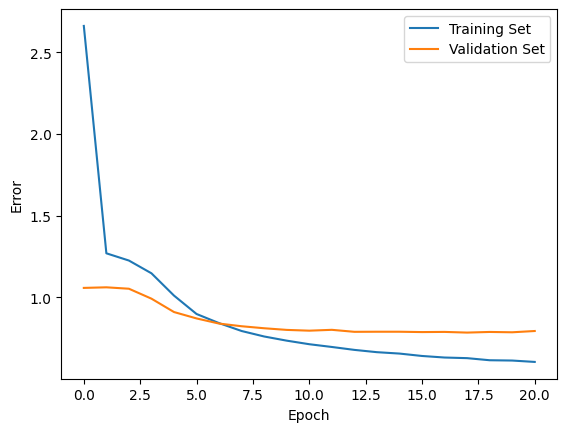

277/277 [==============================] - 0s 431us/step


0.6809177314235544

In [101]:
pd.Series(history.history['loss']).plot(label="Training Set")
pd.Series(history.history['val_loss']).plot(label="Validation Set")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend()
plt.show()

y_hat = np.round(model.predict([test.user_id, test.movie_id]), decimals=2)
y_true = test.rating
mean_absolute_error(y_true, y_hat)

4.06

In [102]:
import evaluation
"mae", evaluation.mean_absolute_error(y_true, y_hat)
"rmse", evaluation.root_mean_squared_error(y_true, y_hat)

('rmse', 0.8866792813769881)

In [130]:
# ['Predicted: {} vs Actual: {}:...........Difference = {}'.format(round(elem[1][0], 2), elem[0], abs(elem[1][0] - elem[0])) for elem in zip(y_true.to_numpy(), y_hat) if abs(elem[1][0] - elem[0]) > 3][:20]

['Predicted: 3.8299999237060547 vs Actual: 0.5:...........Difference = 3.3299999237060547',
 'Predicted: 4.420000076293945 vs Actual: 0.5:...........Difference = 3.9200000762939453',
 'Predicted: 4.300000190734863 vs Actual: 1.0:...........Difference = 3.3000001907348633',
 'Predicted: 3.5899999141693115 vs Actual: 0.5:...........Difference = 3.0899999141693115',
 'Predicted: 4.320000171661377 vs Actual: 1.0:...........Difference = 3.320000171661377',
 'Predicted: 4.269999980926514 vs Actual: 0.5:...........Difference = 3.7699999809265137',
 'Predicted: 3.799999952316284 vs Actual: 0.5:...........Difference = 3.299999952316284',
 'Predicted: 3.880000114440918 vs Actual: 0.5:...........Difference = 3.380000114440918',
 'Predicted: 3.880000114440918 vs Actual: 0.5:...........Difference = 3.380000114440918',
 'Predicted: 4.730000019073486 vs Actual: 1.5:...........Difference = 3.2300000190734863',
 'Predicted: 3.759999990463257 vs Actual: 0.5:...........Difference = 3.259999990463257',
 '

In [11]:
movies = pd.read_csv("./data/movies.csv")

def getUserTopMovies(user_id: int) -> pd.DataFrame:
    movie_ids = test.movie_id.unique()
    predictions = model.predict([np.array([user_id] * len(movie_ids)), movie_ids])
    combined = pd.DataFrame({'movie_id': movie_ids, 'predicted_rating': [_[0] for _ in predictions]})
    #sort ratings descending
    combined = combined.sort_values(by="predicted_rating", ascending=False)
    #append movie titles to DataFrame
    combined = combined.set_index('movie_id').join(movies.set_index('movieId')).drop(columns = ["genres"])
    #drop null entries
    combined = combined.dropna()
    #make movie_id a column
    return combined.reset_index(level=0)


In [12]:
topMovies = getUserTopMovies(111)
topMovies.loc[topMovies.movie_id == 1956]
test.loc[(test.movie_id == 1956) & (test.user_id == 111)]

79/79 [==============================] - 0s 569us/step


,user_id,movie_id,rating,timestamp


In [13]:
topMovies = getUserTopMovies(564)
topMovies.loc[topMovies.movie_id == 1956]
validate.loc[(validate.movie_id == 1956) & (validate.user_id == 564)]

79/79 [==============================] - 0s 557us/step


,user_id,movie_id,rating,timestamp
